In [3]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib
from inference import inference

In [4]:
seed=42;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cpu


num_drones = 100	num_facilities = 10	dim = 2
Data Loaded.


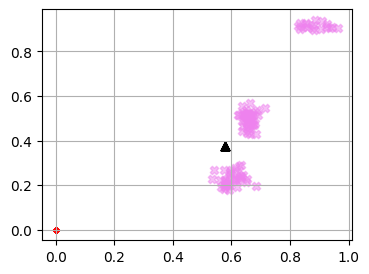

In [5]:
# UAV FLPO MetaData
num_drones = 100
n_drone_clusters = 3
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 10
dim_ = 2
print(f'num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}')

# Assign start location to each drone
drone_cnt = 0
for i in range(n_drone_clusters):
    if i == n_drone_clusters-1:
        n_drones = int(num_drones - drone_cnt)
    else:
        n_drones = int(drone_cluster_split[i] * (num_drones+1))
        drone_cnt += n_drones

    drone_cluster_mean = torch.rand(1, dim_).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_std = ((0.01 - 0.05) * torch.rand(1,dim_) + 0.05).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_START_locs = torch.normal(mean=drone_cluster_mean, std=drone_cluster_std).to(device)
    if i == 0:
        START_locs = drone_cluster_START_locs
    else:
        START_locs = torch.cat((START_locs, drone_cluster_START_locs), axis=0)

assert not START_locs.requires_grad, "set requires_grad for START_locs to 0"
# Assign destination location to each drone
END_locs = torch.zeros((num_drones, 1, dim_), requires_grad=False, device=device) #torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Create the data tensor
F_means = torch.mean(START_locs-0.1, dim=0).repeat(num_facilities, 1)
F_noise = torch.normal(mean=torch.zeros(num_facilities,2,device=device), std=0.0001*torch.ones(num_facilities,2,device=device))
F_base = (F_means + F_noise).unsqueeze(0).requires_grad_()
# print(F_base.shape)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")

# plot the data
def plot_UAV_FLPO(drone_START, drone_END, Facilities, figuresize=(6,5)):
    start_locs = drone_START.squeeze(1).cpu().numpy()
    end_locs = drone_END.squeeze(1).cpu().numpy()
    f_locs = Facilities.squeeze(0).detach().cpu().numpy()

    plt.figure(figsize=figuresize)
    plt.scatter(start_locs[:,0], start_locs[:,1], color='violet', marker='X', alpha=0.5)
    plt.scatter(end_locs[:,0], end_locs[:,1], color='red', marker='.')
    plt.scatter(f_locs[:,0], f_locs[:,1], color='black', marker='^')
    plt.grid()
    plt.show()

plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))


### Create and a dataset for creating an original FLPO framework

In [6]:
node_locations = START_locs.to(torch.float64).numpy().squeeze()
destination_location = END_locs[0].to(torch.float64).numpy()
facility_location = F_base.to(torch.float64).detach().numpy().squeeze()

In [7]:
numpyFLPOdata = {}
numpyFLPOdata['nodeLocations'] = node_locations
numpyFLPOdata['destinationLocation'] = destination_location 
numpyFLPOdata['facilityLocations'] = facility_location
numpyFLPOdata['numFacilities'] = facility_location.shape[0]
numpyFLPOdata['numNodes'] = node_locations.shape[0]
numpyFLPOdata['scale'] = 1.0

In [8]:
import pickle
filename = 'flpo_single_drone_data.pkl'
with open(filename, 'wb') as file:
    pickle.dump(numpyFLPOdata, file)

### Functions for forward pass of VRP and LSE net modules

In [9]:
# Shortest path and its gradient wrt facility locations
def VRPNet_pass(vrp_net, data, method = 'BeamSearch', returnGrad=False):
    
    s = time.time()
    with torch.no_grad():
        actions = inference(data , vrp_net , method)
    e = time.time()
    
    D_min_drones = utils.route_cost(data, actions).view(-1,1)
    if returnGrad:
        gradient = torch.autograd.grad(outputs=D_min_drones, inputs=data,
                                grad_outputs=torch.ones_like(D_min_drones),
                                create_graph=True)
        dDmin_dFlocs = gradient[0][:,1:-1,:]
    else:
        dDmin_dFlocs = None

    return D_min_drones, dDmin_dFlocs, e-s

# Free energy as a function of shortest path, and its gradients
def LSENet_pass(lse_net, D_min_drones, D_max_range, beta, beta_min, returnGrad=False):
    device = D_min_drones.device
    Fmin_est = area_approx_F(D_min_drones, D_max_range=D_max_range, beta=beta_min, printCalculations=False)
    In_lse = torch.cat((
        Fmin_est.to(device),
        D_min_drones,
        (torch.ones(D_min_drones.shape,device=device)*torch.log(torch.tensor([beta],device=device))/torch.log(torch.tensor([10.0],device=device)))
    ), axis=1)
    FreeEnergy = lse_net(In_lse)
    if returnGrad:
        gradient = torch.autograd.grad(outputs=FreeEnergy, inputs=In_lse,
                                grad_outputs=torch.ones_like(FreeEnergy),
                                create_graph=True)
        # dFreeE_dDmin = gradient[0].view(num_drones,1,1)
        dFreeE_dDmin = gradient[0][:,1].view(-1,1).view(num_drones,1,1)
    else:
        dFreeE_dDmin = None

    return FreeEnergy, dFreeE_dDmin


    return FreeEnergy, dFreeE_dDmin

### Load the VRP NET Module

In [10]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = "Saved_models/VRPNet_L_lr1e-04_bs256_ep80000_samples20480000_cities10_inputdim2_workers0_hidden64_enc6_dec3_heads8_dropout0.10_beta10000.000-10000.0_train_supervised_2025_05_13_11_34_05best_model.pth"
vrp_net = utils.load_model(weights_address, model_classes, device=device, weights_only=True)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadAt

In [11]:
# hidden_dim = 32
# num_layers_enc = 1
# num_layers_dec = 1
# num_heads = 8
# torch.cuda.empty_cache()
# vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
# model_name = 'Saved models/VRPNet_L_lr1e-04_bs256_ep80000_samples20480000_cities10_inputdim2_workers0_hidden64_enc6_dec3_heads8_dropout0.10_beta10000.000-10000.0_train_supervised_2025_05_13_11_34_05best_model.pth'
# if torch.cuda.is_available():
#     vrp_net.load_state_dict(torch.load(model_name, weights_only=True))
# else:
#     vrp_net.load_state_dict(torch.load(model_name, weights_only=False, map_location=torch.device('cpu')))
# vrp_net.eval()

# # for param in vrp_net.parameters():
# #     param.requires_grad = False
# print('VRP NET loaded on: ',vrp_net.device)
# print(summary(vrp_net))

In [12]:
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
# print(START_locs)
# print(F_locs)
# print(END_locs)
# print(data)
d_mins, ddmins_dFlocs, _ = VRPNet_pass(vrp_net, data, returnGrad=True)

In [13]:
d_mins

tensor([[0.8586],
        [0.8384],
        [0.8944],
        [0.8424],
        [0.8374],
        [0.8531],
        [0.8259],
        [0.9024],
        [0.8573],
        [0.8981],
        [0.8638],
        [0.8845],
        [0.8974],
        [0.8330],
        [0.8428],
        [0.8892],
        [0.8800],
        [0.8161],
        [0.4987],
        [0.4954],
        [0.5099],
        [0.5080],
        [0.5053],
        [0.4883],
        [0.5015],
        [0.5009],
        [0.4873],
        [0.5198],
        [0.4928],
        [0.4880],
        [0.5078],
        [0.5118],
        [0.4933],
        [0.5008],
        [0.4867],
        [0.5002],
        [0.4971],
        [0.4982],
        [0.4904],
        [0.5028],
        [0.5044],
        [0.4988],
        [0.5020],
        [0.4987],
        [0.4921],
        [0.5001],
        [0.4981],
        [0.5248],
        [0.4985],
        [0.5053],
        [0.5015],
        [0.4931],
        [0.5135],
        [0.4841],
        [0.4915],
        [0

In [14]:
print(ddmins_dFlocs.shape)
ddmins_dFlocs

torch.Size([100, 10, 2])


tensor([[[-3.5965e-04,  6.0022e-05],
         [ 1.6832e-04,  7.9632e-05],
         [ 1.3554e-04, -4.3303e-04],
         ...,
         [ 2.2101e-04, -2.9689e-04],
         [-5.4717e-05,  8.1122e-05],
         [-6.5407e-01, -1.0489e+00]],

        [[-3.5965e-04,  6.0022e-05],
         [ 1.6832e-04,  7.9632e-05],
         [ 1.3554e-04, -4.3303e-04],
         ...,
         [ 2.2101e-04, -2.9689e-04],
         [-5.4717e-05,  8.1122e-05],
         [-6.0402e-01, -1.0403e+00]],

        [[-4.7028e-04, -4.6790e-05],
         [ 8.5950e-05,  4.4286e-05],
         [ 1.1580e+00,  7.5130e-01],
         ...,
         [-6.8188e-05,  3.9589e-04],
         [ 4.0650e-05, -1.8340e-04],
         [-7.3111e-01, -1.0665e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00

### Load the LSE net module

In [15]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_1__17_6_31.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
D_max_range = 2.0 #lse_data['D_max_range']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
# lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Some functions for free energy approximation

In [16]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

def area_approx_F(D_min, D_max_range, beta, printCalculations=False):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max))) + D_min
    
    if printCalculations:
        print(f'min_beta_D_arr:{min_beta_D_arr}')
        print(f'x_max:{x_max}')
        print(f'inside_log:{1/x_max * (1 - torch.exp(-x_max))}')
        print(f'log:{torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        print(f'-1/beta_log:\n{-1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        
    return F_est

In [17]:
b_min = 1e-3
beta = 1e-3
F_lse, dFlse_ddmin = LSENet_pass(lse_net, d_mins, D_max_range, beta, b_min, returnGrad=True)
F_total = torch.mean(F_lse)

In [18]:
dFlse_ddmin

tensor([[[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0

### Apply Chain rule: $\frac{\partial F}{\partial F_{base}} = \sum_{i=1}^N\frac{\partial F}{\partial d^i_{min}} \cdot \frac{\partial d^i_{min}}{\partial F_{base}}$, where $i$ represents drone index.

In [20]:
drone_grads_fbase = dFlse_ddmin * ddmins_dFlocs
drone_grads_fbase

tensor([[[-4.4031e-07,  7.3483e-08],
         [ 2.0607e-07,  9.7490e-08],
         [ 1.6594e-07, -5.3014e-07],
         ...,
         [ 2.7058e-07, -3.6347e-07],
         [-6.6988e-08,  9.9315e-08],
         [-8.0075e-04, -1.2841e-03]],

        [[-4.4031e-07,  7.3483e-08],
         [ 2.0607e-07,  9.7490e-08],
         [ 1.6594e-07, -5.3014e-07],
         ...,
         [ 2.7058e-07, -3.6347e-07],
         [-6.6988e-08,  9.9315e-08],
         [-7.3948e-04, -1.2736e-03]],

        [[-5.7575e-07, -5.7283e-08],
         [ 1.0523e-07,  5.4218e-08],
         [ 1.4176e-03,  9.1979e-04],
         ...,
         [-8.3480e-08,  4.8468e-07],
         [ 4.9767e-08, -2.2453e-07],
         [-8.9507e-04, -1.3057e-03]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00

In [21]:
G = torch.mean(drone_grads_fbase, axis=0)
G

tensor([[-3.6718e-07,  4.4491e-09],
        [ 1.0400e-07,  2.3132e-10],
        [ 1.3281e-04,  1.0969e-04],
        [-1.9681e-07, -1.8212e-07],
        [ 4.0662e-04,  2.6421e-04],
        [ 7.8375e-08,  9.9269e-08],
        [ 1.8514e-07,  5.7678e-08],
        [ 3.5435e-04,  2.3025e-04],
        [ 1.2233e-08, -7.5511e-09],
        [-1.3569e-04, -3.1677e-04]], grad_fn=<MeanBackward1>)

### Compute gradient $\frac{\partial F}{\partial F_{base}}$ by direct backpropagation

In [22]:
G1 = torch.autograd.grad(outputs=F_total, inputs=F_base,
                               grad_outputs=torch.ones_like(F_total),
                               create_graph=True)
G1[0]

tensor([[[-1.5079e-04,  1.8286e-06],
         [ 4.2756e-05,  1.0040e-07],
         [ 5.4741e-02,  4.5109e-02],
         [-8.0773e-05, -7.4787e-05],
         [ 1.6701e-01,  1.0852e-01],
         [ 3.2150e-05,  4.0753e-05],
         [ 7.5962e-05,  2.3716e-05],
         [ 1.4541e-01,  9.4485e-02],
         [ 5.0267e-06, -3.1181e-06],
         [-5.5937e-02, -1.3021e-01]]], grad_fn=<SumBackward1>)

### Compute gradient $\frac{\partial F}{\partial F_{base}}$ by using torch.optim.optimizer.backward()

### Compare the gradient estimates with original FLPO framework

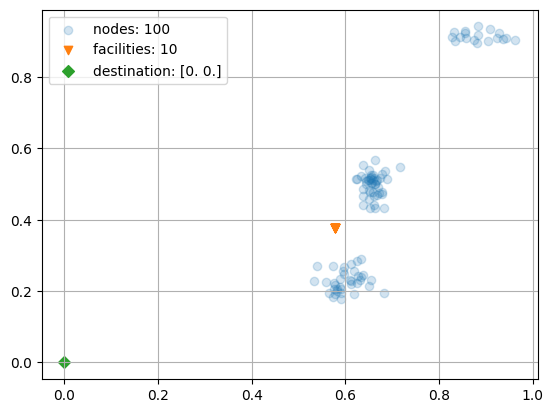

array([[0.09522383, 0.05516306],
       [0.09575924, 0.05530144],
       [0.09615038, 0.05475917],
       [0.09539971, 0.05490595],
       [0.09612466, 0.05535224],
       [0.09577386, 0.05512544],
       [0.09561849, 0.05511719],
       [0.09596176, 0.05528234],
       [0.09590801, 0.05502252],
       [0.09572716, 0.05585042]])

In [21]:
import classFLPO
flpo = classFLPO.FLPO(filename, plotFLPO=True, disType='sqeuclidean', selfHop=True)
Y = flpo.facilityLocations
GD_s, _ = flpo.returnStagewiseGrad(Y)
D_s, _ = flpo.returnStagewiseCost(Y)
_, V, Fe, _, Pb = flpo.backPropDP(D_s, beta, returnPb=True)
GV, GFe = flpo.backPropDP_grad(GD_s, Pb)
# print(GD_s)
GFe
# GV[0].shape

In [22]:
np.mean(np.sum((GFe - G1[0].detach().numpy())**2,axis=1))#/np.mean(np.sum(GFe**2,axis=1))

0.0721742404093518

In [23]:
n_routes = utils.num_flpo_routes(num_facilities, num_drones)
n_routes[0][0]

11111111111

In [24]:
F_total - 1/beta * np.log(n_routes[0][0])

tensor(-23129.9414, grad_fn=<SubBackward0>)

In [25]:
np.mean(V[0]) #+ 1/beta * np.log(n_routes[0][0]))

-23130.646496963338

### Perform a gradient descent step: $F_{base}^+ = F_{base} - \eta \frac{\partial F}{\partial F_{base}}$

In [26]:
F_base

tensor([[[0.5787, 0.3759],
         [0.5788, 0.3759],
         [0.5789, 0.3758],
         [0.5787, 0.3758],
         [0.5789, 0.3759],
         [0.5788, 0.3759],
         [0.5788, 0.3759],
         [0.5789, 0.3759],
         [0.5789, 0.3758],
         [0.5788, 0.3761]]], requires_grad=True)

In [27]:
eta = 0.001
F_base_new = F_base - eta * G

RuntimeError: The size of tensor a (10) must match the size of tensor b (12) at non-singleton dimension 1

In [29]:
F_base_new

tensor([[[0.4382, 0.3312],
         [0.3591, 0.2521]]], grad_fn=<SubBackward0>)

### Write a loop to optimize the network w.r.t. facilities

In [30]:
iters = 2
eta = 0.001
F_base_new = F_base

for i in range(iters):
    
    F_locs = F_base_new.expand(num_drones, -1, -1)  # view, shares grad with F_base
    data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)

    s = time.time()
    with torch.no_grad():
        # forward pass: no activations are saved for grad
        _, actions = vrp_net(data, mod='eval_greedy')
    e = time.time()
    actions.detach()
    d_mins = utils.route_cost(data, actions).view(-1,1)

    gradient0 = torch.autograd.grad(outputs=d_mins, inputs=F_locs,
                               grad_outputs=torch.ones_like(d_mins),
                               create_graph=True)

    d_mins = utils.route_cost(data, actions).view(-1,1) #[drone_id:drone_id+1]
    Fmin_est = area_approx_F(d_mins, D_max_range=2.0, beta=b_min, printCalculations=False)
    torch.cuda.empty_cache()
    In_lse = torch.cat((
        Fmin_est.to(device),
        io_scale * d_mins,
        (torch.ones(d_mins.shape)*torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0]))).to(device)
    ), axis=1)
    
    FreeEnergy = lse_net(In_lse)
    gradient1 = torch.autograd.grad(outputs=FreeEnergy, inputs=In_lse,
                               grad_outputs=torch.ones_like(FreeEnergy),
                               create_graph=True)
    total_gradient = gradient0[0] * gradient1[0][:,1].view(-1,1).view(num_drones,1,1)
    G = torch.sum(total_gradient, axis=0)
    F_base_new = F_base - eta * G